### Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Вспомогательные функции

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv('data/train.csv')
train_df = reduce_mem_usage(train_df)
train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.8%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.00000,NaN,10.0,4,10.0,2014,0.075439,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.40625,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float16 
 3   Square         10000 non-null  float16 
 4   LifeSquare     7887 non-null   float16 
 5   KitchenSquare  10000 non-null  float16 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float16 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float16 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float16 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [6]:
test_df = pd.read_csv('data/test.csv')
test_df = reduce_mem_usage(test_df)
test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.15 MB
Decreased by 79.5%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.84375,19.09375,5.0,5,9.0,1970,0.036133,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.50000,42.56250,10.0,7,17.0,2017,0.072144,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.46875,NaN,9.0,19,19.0,1977,0.211426,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.65625,33.90625,6.0,2,2.0,1965,0.014076,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.84375,NaN,1.0,8,17.0,1977,0.309570,B,B,35,7715,4,990.0,0,6,B


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float16 
 3   Square         5000 non-null   float16 
 4   LifeSquare     3959 non-null   float16 
 5   KitchenSquare  5000 non-null   float16 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float16 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float16 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float16 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [8]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df = train_df.drop('Id', axis =1) # удаляем, так как не нужен

In [10]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.00000,NaN,10.0,4,10.0,2014,0.075439,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,22,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,1,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,1,1.0,40.40625,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,94,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,B,B,33,8667,2,NaN,0,6,B,343995.093750


### Обзор данных

### Целевая переменная

In [11]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

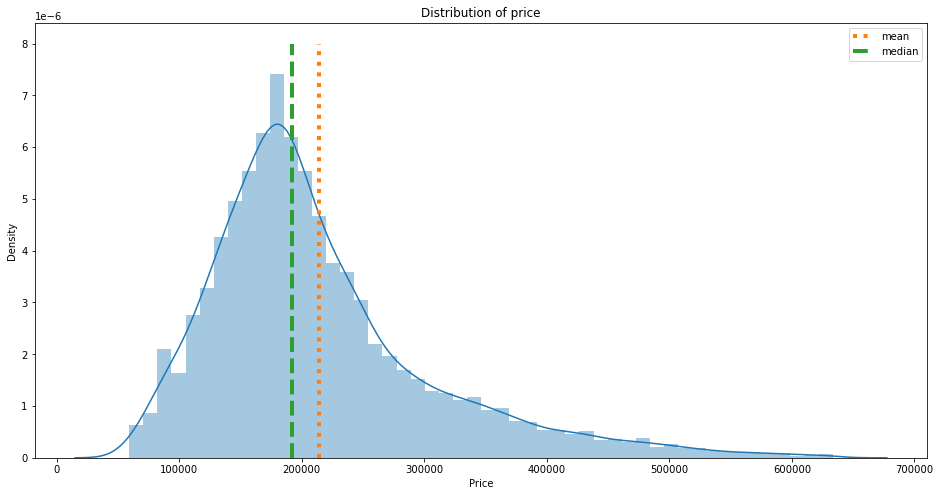

In [12]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
#plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)
    
plt.title('Distribution of price')
plt.legend()
plt.show()

### Количественные признаки

In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.891602e+00,8.398438e-01,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,inf,inf,1.136719,41.781250,52.500000,65.875000,6.410000e+02
LifeSquare,7887.0,inf,inf,0.370605,22.765625,32.781250,45.125000,7.480000e+03
KitchenSquare,10000.0,6.273438e+00,inf,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700e+00,5.241148e+00,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,inf,6.777344e+00,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3.990166e+03,2.005003e+05,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,1.188965e-01,1.190186e-01,0.000000,0.017654,0.075439,0.195801,5.219727e-01
Social_1,10000.0,2.468700e+01,1.753261e+01,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5.352157e+03,4.006800e+03,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


In [14]:
df_num_features = train_df.select_dtypes(include=['float16', 'int16', 'int8', 'float32', 'int32'])
df_num_features.drop('Price', axis=1, inplace=True)

In [15]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.00000,NaN,10.0,4,10.0,2014,0.075439,11,3097,0,NaN,0,0
1,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,30,6207,1,1183.0,1,0
2,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,33,5261,0,240.0,3,1
3,1.0,40.40625,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,33,8667,2,NaN,0,6


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

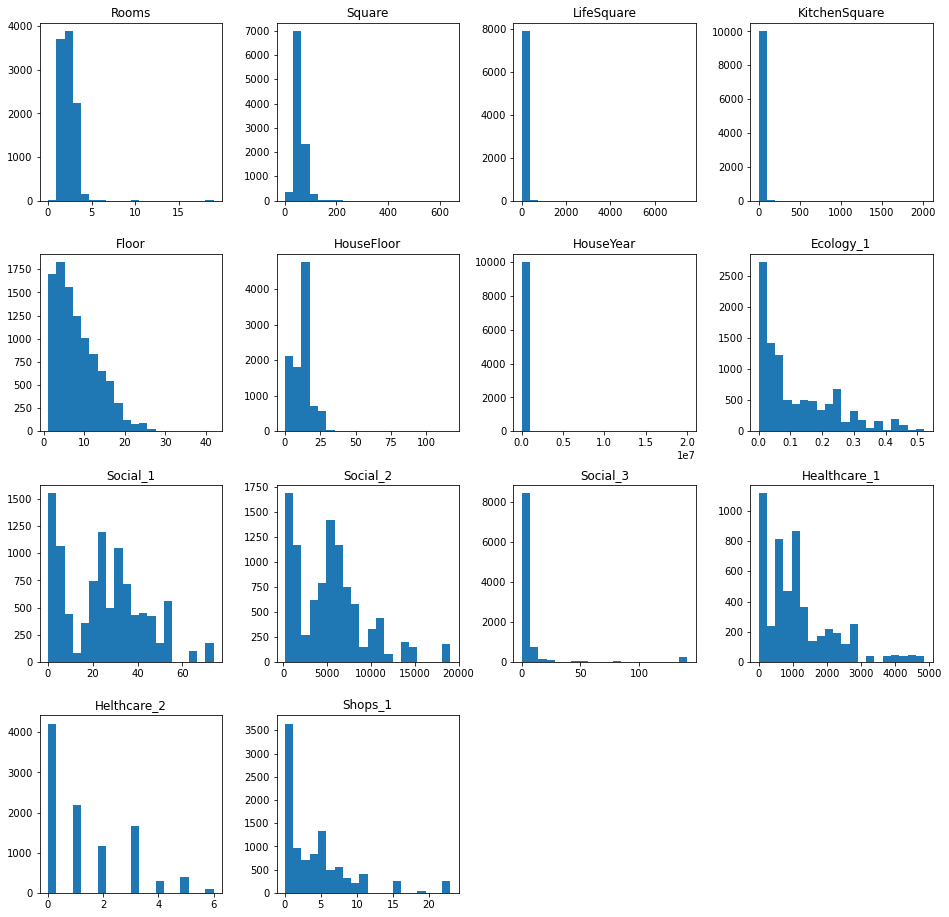

In [16]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

###  Категориальные признаки

In [17]:
train_df.select_dtypes(include='object').columns.tolist()

['DistrictId']

In [18]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [19]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [20]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [21]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

#### Rooms

In [22]:
train_df['Rooms'].value_counts().sort_index(ascending=True)

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

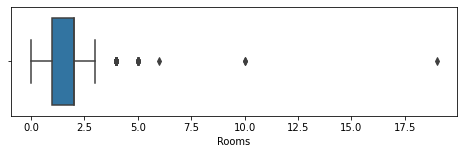

In [23]:
plt.figure(figsize=(8, 2))
sns.boxplot(train_df['Rooms'])
plt.xlabel('Rooms')
plt.show()

Исходил из логики, что 0 комнат - это скорее всего "студии", поэтому присвоил им 1. Также 10 и 19 комнат как-то слишком много, поэтому присвоил им мелдианное значение. Добавил новый признак, отмечающий выбросы.

In [24]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,27,3.0,115.00000,NaN,10.0,4,10.0,2014,0.075439,B,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,22,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,B,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,1,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,B,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,1,1.0,40.40625,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000,0
4,94,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,B,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [25]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

In [26]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

#### Square

In [27]:
train_df['Square'].value_counts().sort_index(ascending=True)

1.136719      1
1.989258      1
2.376953      1
2.595703      1
2.955078      1
             ..
212.875000    1
275.750000    1
409.500000    1
604.500000    1
641.000000    1
Name: Square, Length: 1916, dtype: int64

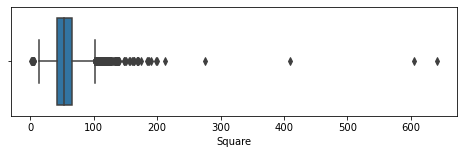

In [28]:
plt.figure(figsize=(8, 2))
sns.boxplot(train_df['Square'])
plt.xlabel('Square')
plt.show()

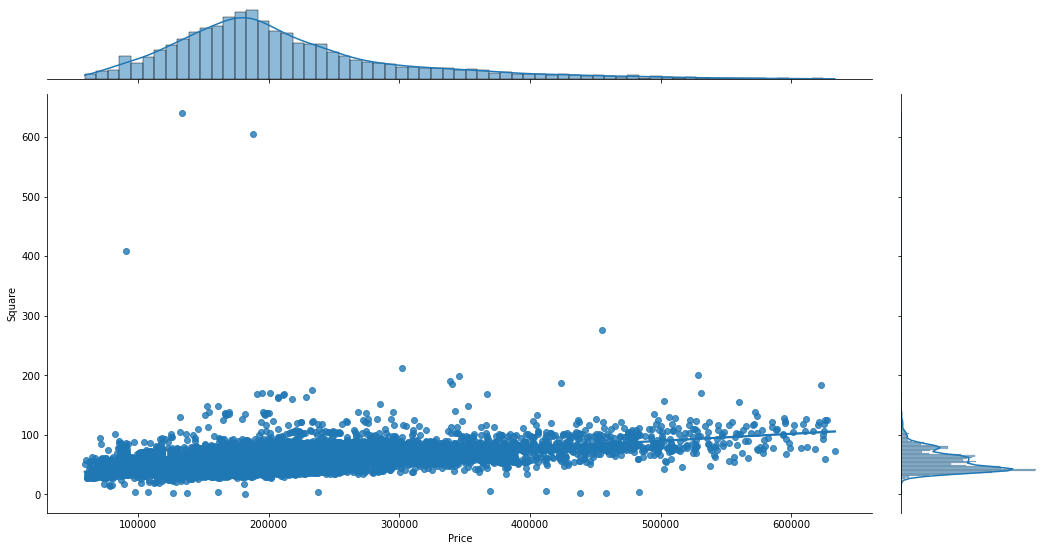

In [29]:
grid = sns.jointplot(train_df['Price'], train_df['Square'], kind='reg')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(8)

plt.show()

Буду считать выбросами площади более 250 и менее 10. Также заменю их медианой.

In [30]:
train_df.loc[train_df['Square'] > 250, 'Square'] = train_df['Square'].median()
train_df.loc[train_df['Square'] <= 10, 'Square'] = train_df['Square'].median()

#### KitchenSquare

In [31]:
train_df['KitchenSquare'].value_counts().sort_index(ascending=True)

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

Как и в разборе считаю будет оптимальным обработка через квантили. Если площаль кухни больше quantile(.975), то заменяем на медиану. Если кухня меньше 3, то приравниваем к 3.

In [32]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df['KitchenSquare'].value_counts().sort_index(ascending=True)

3.0     3183
4.0       39
5.0     1169
6.0     1227
7.0      609
8.0     1306
9.0      843
10.0    1075
11.0     233
12.0     249
13.0      67
Name: KitchenSquare, dtype: int64

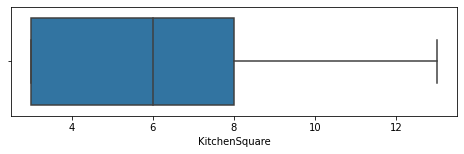

In [33]:
plt.figure(figsize=(8, 2))
sns.boxplot(train_df['KitchenSquare'])
plt.xlabel('KitchenSquare')
plt.show()

#### HouseFloor, Floor

In [34]:
train_df['HouseFloor'].value_counts().sort_index(ascending=True)

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

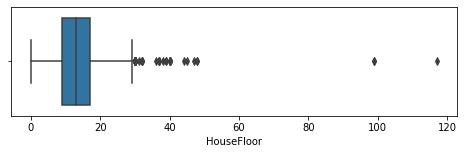

In [35]:
plt.figure(figsize=(8, 2))
sns.boxplot(train_df['HouseFloor'])
plt.xlabel('HouseFloor')
plt.show()

In [36]:
train_df['Floor'].value_counts().sort_index(ascending=True)

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

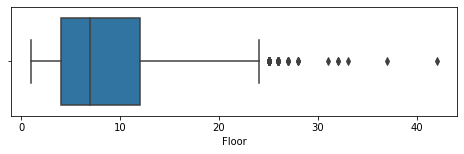

In [37]:
plt.figure(figsize=(8, 2))
sns.boxplot(train_df['Floor'])
plt.xlabel('Floor')
plt.show()

In [38]:
(train_df['Floor'] > train_df['HouseFloor']).sum() # проверяем есть ли квартиры на этажах выше этажности дома

1825

Добавляем новый признак и помечаем "1" те объекты, у которых 0-й этаж и этаж больше этажности дома. Также заменим 0-е этажи на медианное значение.

In [39]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [40]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Обработаем значения этажей объектов, которые больше этажности домов через рандом (как в разборе)

In [41]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

In [42]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

#### HouseYear

In [43]:
train_df['HouseYear'].value_counts().sort_index(ascending=True)

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [44]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

#### Обработка пропусков

In [45]:
train_df.isna().sum()

DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

Есть пропуски в двух признаках. Жилую площадь модно вычислить примерно - из общей вычесть площадь кухни и еще квадратов 6 на все остальное. Также добавлю еще один категориальный признак и помечу пропуски. С Healthcare_1 сложнее. Рассматривал два варианта: либо выбросить этот признак из рассмотрения или заменить пропуски медианой.

In [46]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1
condition = (train_df['LifeSquare'].isna()) & (~train_df['Square'].isna()) & (~train_df['KitchenSquare'].isna())
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare'] - 6


In [47]:
train_df['Healthcare_1_NaN'] = 0
train_df.loc[(train_df['Healthcare_1'].isna()), 'Healthcare_1_NaN'] = 1
train_df.loc[(train_df['Healthcare_1'].isna()), 'Healthcare_1'] = train_df['Healthcare_1'].median()

#### Построение новых признаков

In [48]:
binary_to_numbers = {'A': 0, 'B': 1}

In [49]:
train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [50]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [51]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_NaN,DistrictSize
0,27,3.0,115.00000,99.000000,10.0,4,10.0,2014,0.075439,1,...,900.0,0,0,1,305018.875000,0,0,1,1,851
1,22,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,1,...,1183.0,1,0,1,177734.546875,0,0,0,0,78
2,1,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,1,...,240.0,3,1,1,282078.718750,0,0,0,0,652
3,1,1.0,40.40625,31.406250,3.0,10,22.0,1977,0.007122,1,...,900.0,0,1,1,168106.000000,0,0,1,1,652
4,94,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,1,...,900.0,0,6,1,343995.093750,0,0,0,1,89


In [52]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [53]:
median_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'Median_price_by_district'})
median_price_by_district.head()

,DistrictId,Rooms,Median_price_by_district
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [54]:
train_df = train_df.merge(median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_NaN,DistrictSize,IsDistrictLarge,Median_price_by_district
0,27,3.0,115.00000,99.000000,10.0,4,10.0,2014,0.075439,1,...,0,1,305018.875000,0,0,1,1,851,1,213530.781250
1,22,1.0,39.84375,23.171875,8.0,7,8.0,1966,0.118530,1,...,0,1,177734.546875,0,0,0,0,78,0,146032.828125
2,1,3.0,78.31250,47.687500,10.0,2,17.0,1988,0.025604,1,...,1,1,282078.718750,0,0,0,0,652,1,244005.281250
3,1,1.0,40.40625,31.406250,3.0,10,22.0,1977,0.007122,1,...,1,1,168106.000000,0,0,1,1,652,1,146735.671875
4,94,2.0,64.31250,38.562500,9.0,16,16.0,1972,0.282715,1,...,6,1,343995.093750,0,0,0,1,89,0,201584.437500


#### Обработкa данных

In [55]:
class DataPreprocessing:
    

    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None
        
        
    def fit(self, X):
        
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        

    
    
    def transform(self, X):
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #Square
        X.loc[train_df['Square'] > 250, 'Square'] = self.medians['Square']
        X.loc[train_df['Square'] <= 10, 'Square'] = self.medians['Square']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1_NaN'] = X['Healthcare_1'].isna() * 1
        X.loc[(X['Healthcare_1'].isna()), 'Healthcare_1'] = self.medians['Healthcare_1']
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 6
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [56]:
class FeatureGenetator():
    
    def __init__(self):

        self.binary_to_numbers = None
        self.district_size = None
        self.median_price_by_district = None
        
        
    def fit(self, X, y=None):
        X = X.copy()
        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.district_size = X['DistrictId'].value_counts().reset_index()\
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        if y is not None:
            X['Price'] = y.values
            self.median_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'Median_price_by_district'})
            self.median_price_by_district_median = self.median_price_by_district['Median_price_by_district'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # Age categories 
        X['age_cat'] = 3
        X.loc[X['HouseYear'] <= 2000, 'age_cat'] = 2 
        X.loc[X['HouseYear'] <= 1980, 'age_cat'] = 1
        X.loc[X['HouseYear'] <= 1950, 'age_cat'] = 0
        
        # First and last floors categories
        X['floor_cat'] = 1
        X.loc[(X['Floor'] == 1) | (X['Floor'] == X['HouseFloor']), 'floor_cat'] = 0
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        
        if self.median_price_by_district is not None:
            X = X.merge(self.median_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['Median_price_by_district'].fillna(self.median_price_by_district_median, inplace=True)
            
        return X
            
        

 
 #### Вновь загружаем данные, разбиваем и обрабатываем
 

In [57]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [58]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.35 MB
Decreased by 76.8%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.15 MB
Decreased by 79.5%


In [59]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [60]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize',\
                     'IsDistrictLarge', 'age_cat', 'floor_cat']

## исключил Median_price_by_district, так как оказывал большое влияние и HouseYear_outlier, так как вклад не значительный

target_name = 'Price'

In [61]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [63]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [64]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Id                        5000 non-null   int16   
 1   DistrictId                5000 non-null   int16   
 2   Rooms                     5000 non-null   float16 
 3   Square                    5000 non-null   float16 
 4   LifeSquare                5000 non-null   float16 
 5   KitchenSquare             5000 non-null   float16 
 6   Floor                     5000 non-null   int64   
 7   HouseFloor                5000 non-null   float16 
 8   HouseYear                 5000 non-null   int16   
 9   Ecology_1                 5000 non-null   float16 
 10  Ecology_2                 5000 non-null   category
 11  Ecology_3                 5000 non-null   category
 12  Social_1                  5000 non-null   int8    
 13  Social_2                  5000 non-null   int16 

In [66]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### Строим модели и выбираем

Линейная регрессия

Train R2:	0.582
Test R2:	0.523


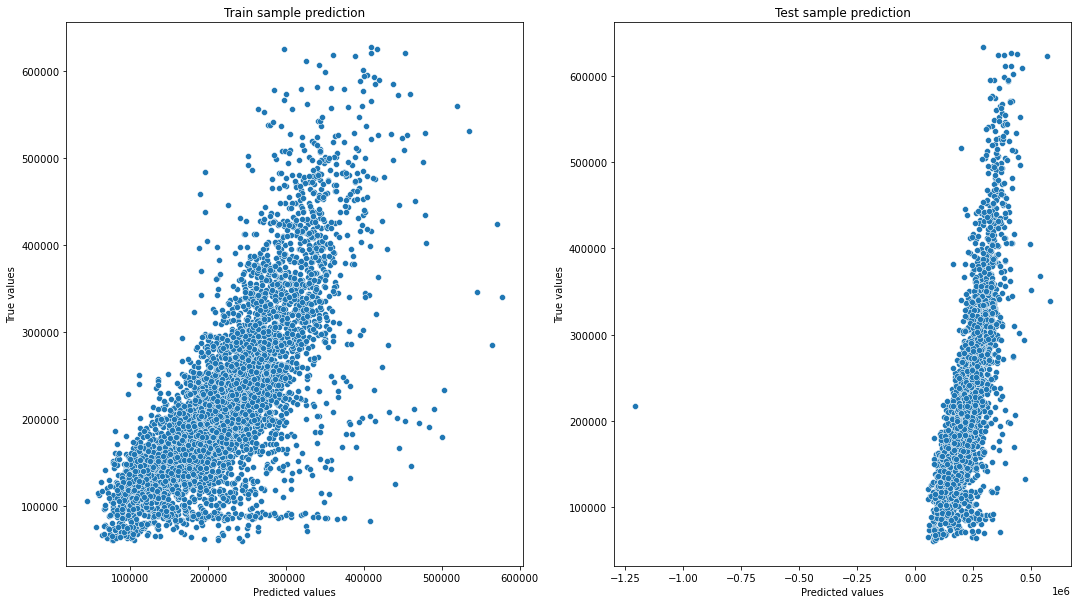

In [67]:
#from sklearn.linear_model import LinearRegression
#lr_model = LinearRegression()

#lr_model.fit(X_train, y_train)
             
#y_train_preds = lr_model.predict(X_train)
#y_test_preds = lr_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

RandomForestRegressor

Train R2:	0.869
Test R2:	0.724


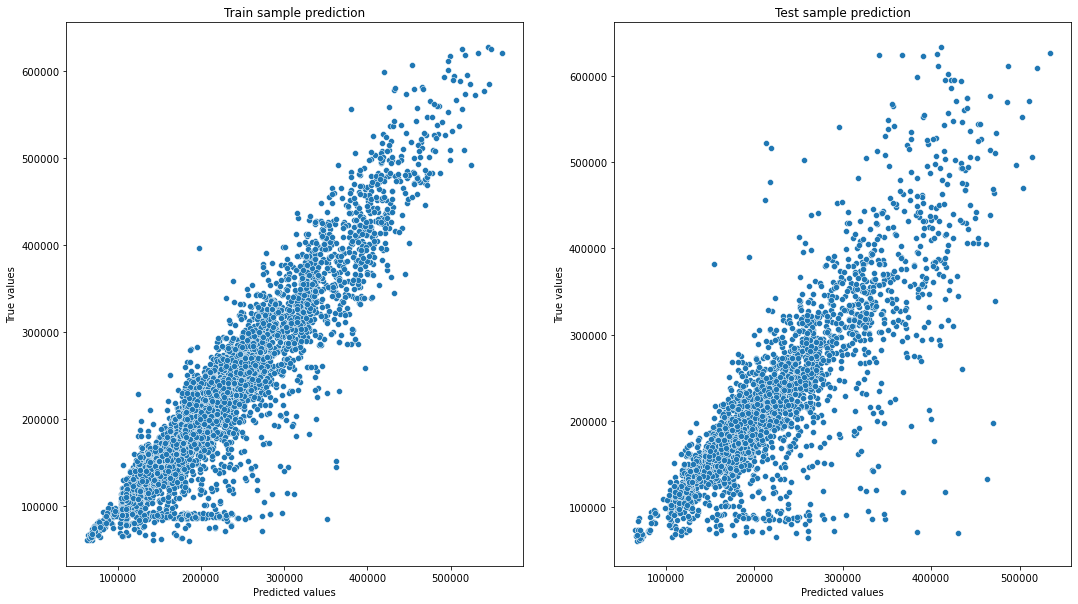

In [69]:
#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor (n_estimators=1000, max_depth=10, random_state=42)
#rf_model.fit(X_train, y_train)

#y_train_preds = rf_model.predict(X_train)
#y_test_preds = rf_model.predict(X_valid)

#evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [70]:
#cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True,random_state=1))
#cv_score.mean()

0.7174430249493596

In [71]:
#feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),columns=['feature_name', 'importance'])
#feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.460928
19,DistrictSize,0.263483
12,Social_3,0.055522
7,Ecology_1,0.029014
6,HouseYear,0.027029
2,LifeSquare,0.024885
0,Rooms,0.024425
11,Social_2,0.024229
10,Social_1,0.023352
5,HouseFloor,0.018102


GradientBoostingRegressor

Train R2:	0.887
Test R2:	0.743


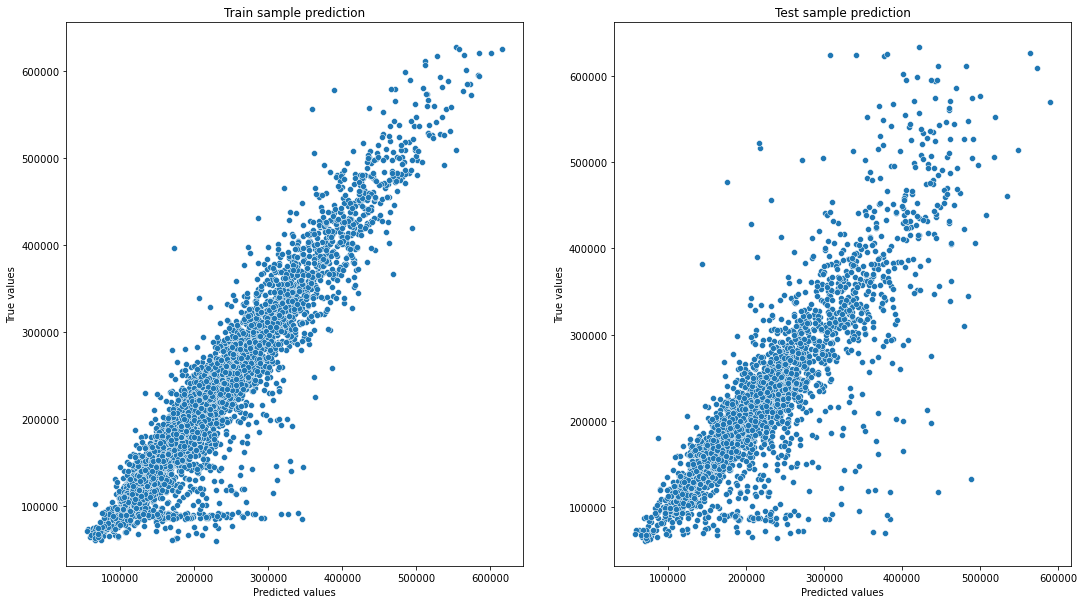

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
f_model = GradientBoostingRegressor( random_state=42, 
                                     max_depth=4,
                                     max_features=3,
                                     n_estimators=500, 
                                     learning_rate=0.1).fit(X_train, y_train)
y_train_preds = f_model.predict(X_train)
y_test_preds = f_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [74]:
cv_score = cross_val_score(f_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True,random_state=1))
cv_score.mean()

0.7400651164692004

In [75]:
feature_importances = pd.DataFrame(zip(X_train.columns, f_model.feature_importances_),columns=['feature_name', 'importance'])

In [76]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.230086
0,Rooms,0.148383
2,LifeSquare,0.089895
12,Social_3,0.078531
19,DistrictSize,0.076071
20,IsDistrictLarge,0.057259
10,Social_1,0.054010
6,HouseYear,0.053288
3,KitchenSquare,0.037331
7,Ecology_1,0.037053


#### Делаем прогноз по тестовым данным

In [78]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [79]:
predictions = f_model.predict(test_df)
predictions

array([162067.73301727, 127931.09045482, 148423.72521466, ...,
       149732.74200697, 185010.45745905, 257721.05787894])

In [80]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162067.733017
1,5925,127931.090455
2,960,148423.725215
3,3848,122398.680551
4,746,210295.055750


In [81]:
submit.to_csv('EDemidov_submit.csv', index=False)